# Tutorial 2 - Analysis of impedance data
For the last tutorial, let's see how we can analyze data; the module needed is
`impedance_analysis.py`.\
As in the previuous tutorial, let's add the parent folder path to import the
functions that we need.

In [1]:
import sys
from pathlib import Path
sys.path.append(str(Path.cwd().parent)) 

## Two-element circuit
The first thing to do is to set in the configuration file the file name from
which we want to read the data. The allowed formats are either frequency vs
complex impedance or frequency vs impedance modulus and impedance phase.\
Let's suppose we have a file containing the generated data of an RC series
circuit named `RC_series_data.txt`, in the `Data_tutorial` folder.\
The generation parameter are $R = 3\,k\Omega$ and $C = 2\,\mu F$, but
obviously let's pretend we do not know that yet.\
In the configuration file

[File]\
file_name = Data_tutorial/RC_series_data

NB: There is a try-except on the file name, therefore check that the file name is
valid.

As before let's read the configuration file first

In [2]:
import configparser

config = configparser.ConfigParser()
config.read('Configs_tutorial/config_analysis_RC_series.ini')

['Configs_tutorial/config_analysis_RC_series.ini']

Then we can read the data file and import the frequency array and the complex
impedance array with


In [3]:
from read import read_input_file_name, read_data

file_name = read_input_file_name(config)
frequency, impedance_data = read_data(file_name)

To check which data we imported, we can also plot the impedance modulus and
phase as function of frequency (and save the graph)

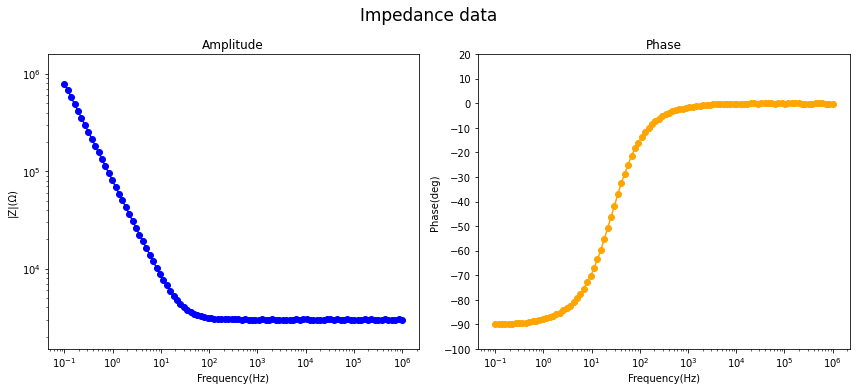

In [4]:
from plot_and_save import plot_data

plot_data(frequency, impedance_data)

Now, we know by hypothesis that the correspondant circuit string is `(R1C2)`,
and we suppose that the values of the elements are $R = 5\,k\Omega$ and
$C = 1\,\mu F$. Suppose also that we want to consider both the elements values
in the fit, thus the constant conditions are all False (i.e. `0`),
then in the configuration file (now `config_analysis_RC_series.ini`) we have

[Circuit]\
diagram = (R1C2)

[Parameters]\
R1 = 5000\
C2 = 1e-6

[Constant_conditions]\
R1 = 0\
C2 = 0

From the configuration file the data are read into the python module

In [5]:
from impedance_analysis import read_input_circuit_diagram, read_input_parameters
from impedance_analysis import read_input_constant_parameter_configurations_fit
from impedance_analysis import generate_circuit

circuit_diagram = read_input_circuit_diagram(config)
parameters = read_input_parameters(config)
constant_conditions = read_input_constant_parameter_configurations_fit(config)

circuit_fit_rc = generate_circuit(circuit_diagram, parameters,
                                  constant_conditions)

From this settings, the impedance function and the initial fitting parameters
of the circuit are

In [6]:
analyzed_circuit_fit_rc = circuit_fit_rc.generate_analyzed_circuit()

impedance_function = analyzed_circuit_fit_rc.impedance
initial_parameters = analyzed_circuit_fit_rc.list_parameters()

while the initial error to be minimized during the fit (which is defined in
the error function specified also in the ReadMe file) is

In [7]:
from impedance_analysis import error_function

circuit_fit_rc.error = error_function(initial_parameters, impedance_data,
                                      impedance_function, frequency)

We can also print these initial settinge just with a method of the `Circuit`
class

In [8]:
initial_parameters_string = circuit_fit_rc.get_parameters_info()
print('\nInitial fit parameters:\n' + initial_parameters_string)


Initial fit parameters:
R1: 5000.0
C2: 1e-06
Error: 78.5080


Let's move to the core part of the module: the fitting process. The fitting
function returns the optimized parameters and the convergence (i.e. if the
fit was successful or not) outcome given by the minimization process.

Note 1: the maximum iteration is set to 1000, and this number is rarely
reached with circtuits composed by less than 6 elements.\
Note 2: there are some bound restrictions on the parameters, based on the
elemenet type, to help the fit function to converge. They are stated in the
`bounds_definitions` function and they are
- [10 $\Omega$, $None$] for resistances
- [1 $nF$, $None$] for capacitances and Qs
- [0, 1] for ideality factors


In [9]:
from impedance_analysis import fit

optimized_parameters, success_flag = fit(frequency, impedance_data,
                                         analyzed_circuit_fit_rc)
print('Success flag: ' + success_flag)

Success flag: True


After the final error is calculated, the fit results are printed in the
command line as a `string`

In [10]:
from impedance_analysis import get_results_info

final_error = error_function(optimized_parameters, impedance_data,
                             impedance_function, frequency)

results_string = get_results_info(analyzed_circuit_fit_rc, final_error,
                                  circuit_fit_rc)
print('\nOptimized fit parameters:\n' + results_string)


Optimized fit parameters:
R1: 2999.766
C2: 2.00118e-06
Error: 0.2576


Just by looking at the optimized results we can see how small is the gap with
the generation parameters ($R = 3\,k\Omega$ and $C = 2\,\mu F$). Remember also
that we introduced pseudo-random noise, that could alter ther effective values
of the parameters.\
We also would like to plot and save the fit superimposed to the data

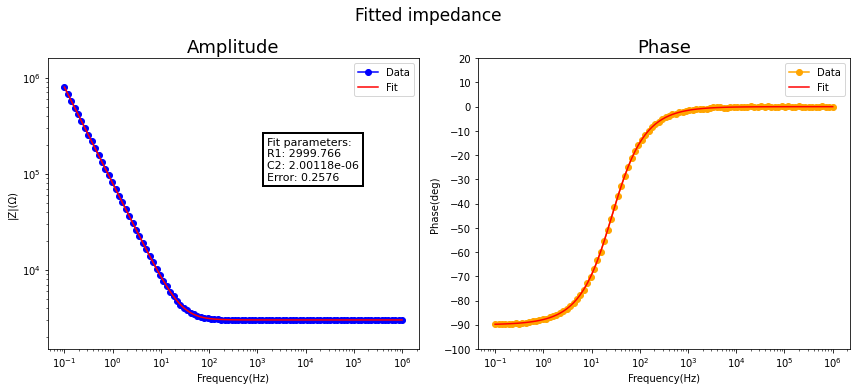

In [11]:
from plot_and_save import plot_fit

final_impedance_calculated = impedance_function(optimized_parameters,
                                                frequency)
plot_fit(frequency, impedance_data, final_impedance_calculated,
         results_string)

The red line (the fit) perfectly matches the points, even if we set the double
of the value for the resistance and half of the value for the capacitance.\
In fact, this algorithm is accurate as long as there is no more than order of
magnitute between the inital values and the actual values of each fitting
parameters.

## Four-element circuit
Let's consider a more complex case: the `(R1C2[R3Q4])` circuit. Now the file
name for the data will be `four_elements_data.txt`, and the file data format
is in impedance modulus and phase instead of complex impedance.\
The generation parameter are $R1 = 3\,k\Omega$, $C2 = 2\,\mu F$,
$R3 = 10\,k\Omega$ and $Q = 200\,nF$ and $n = 0.82$.

In the configuration file\
[File]\
file_name = Data_tutorial/four_elements_data

In [12]:
config = configparser.ConfigParser()
config.read('Configs_tutorial/config_analysis_many_elements.ini')

file_name = read_input_file_name(config)

If we plot what we imported we get

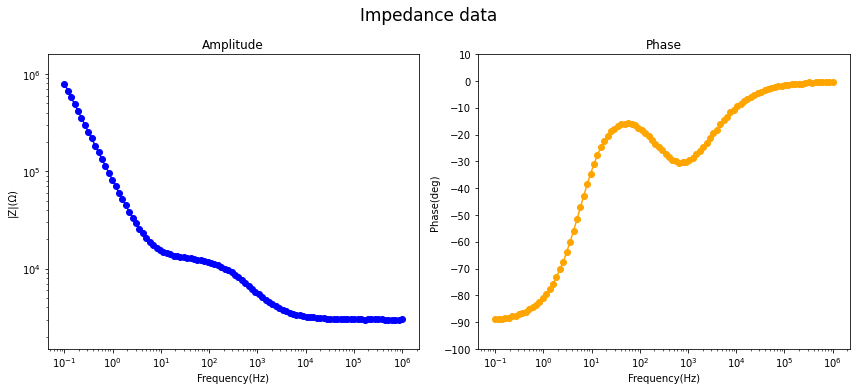

In [13]:
frequency, impedance_data = read_data(file_name)
plot_data(frequency, impedance_data)

Suppose that from another analysis we know that the value of $R3$ is
$10\,k\Omega$, thus here it will be set constant. As initial values of the
other elements we set $R1 = 7\,k\Omega$, $C2 = 8\,\mu F$, $Q = 70\,nF$ and
$n = 0.7$.

In the configuration file\
[Circuit]\
diagram = (R1C2[R3Q4])

[Parameters]\
R1 = 7000\
C2 = 8e-6\
R3 = 10000\
Q4 = 0.07e-6 0.7

[Constant_conditions]\
R1 = 0\
C2 = 0\
R3 = 1\
Q4 = 0


In [14]:
circuit_diagram = read_input_circuit_diagram(config)
parameters = read_input_parameters(config)
constant_conditions = read_input_constant_parameter_configurations_fit(config)

As done in the last example, let's generate the impedance function of the
circuit, with the starting values of the fitting parameters and the
corresponding fitting elements list, and calculate the initial error with this
setting

In [15]:
circuit_fit_complex = generate_circuit(circuit_diagram, parameters,
                                       constant_conditions)
analyzed_circuit_fit_complex = circuit_fit_complex.generate_analyzed_circuit()

impedance_function = analyzed_circuit_fit_complex.impedance
initial_parameters = analyzed_circuit_fit_complex.list_parameters()
circuit_fit_complex.error = error_function(initial_parameters, impedance_data,
                                      impedance_function, frequency)

To print this initial setting

In [16]:
initial_parameters_string = circuit_fit_complex.get_parameters_info()
print('\nInitial fit parameters:\n' + initial_parameters_string)


Initial fit parameters:
R1: 7000.0
C2: 8e-06
R3: 10000.0 (constant)
Q4: 7e-08, 0.7
Error: 123.0117


Now, let's fit

In [17]:
optimized_parameters, success_flag = fit(frequency, impedance_data,
                                         analyzed_circuit_fit_complex)
print('Success flag: ' + success_flag)

Success flag: True


The results are

In [18]:
final_error = error_function(optimized_parameters, impedance_data,
                             impedance_function, frequency)

results_string = get_results_info(analyzed_circuit_fit_complex, final_error,
                                  circuit_fit_complex)
print('\nOptimized fit parameters:\n' + results_string)


Optimized fit parameters:
R1: 3000.259
C2: 2.00009e-06
R3: 10000.0 (constant)
Q4: 1.9937e-07, 0.82
Error: 0.2604


Quite similar to the generation parameters!

The relative plot is

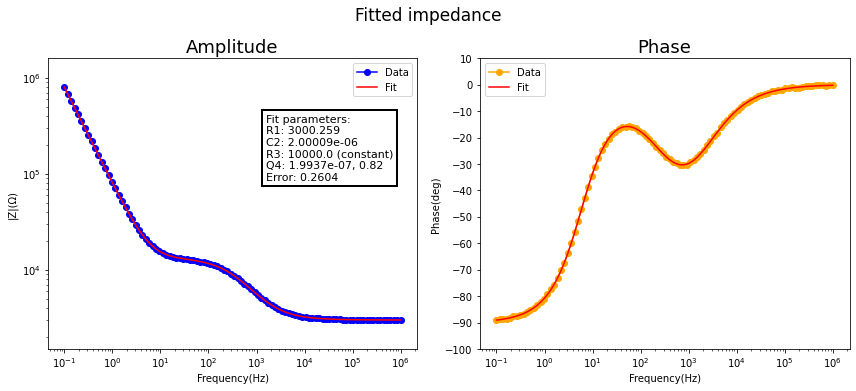

In [19]:
final_impedance_calculated = impedance_function(optimized_parameters,
                                                frequency)
plot_fit(frequency, impedance_data, final_impedance_calculated,
         results_string)

Again, the optimized parameters calculated by the fit well describes the
impedance data, given that the equivalent circuit is the same.

With this last example, the tutorials end.